# Graphing the data from Template_run_Auto.py

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import astropy.stats
import math
import global_settings as gs

In [2]:
os.getcwd()
test_title = 'test_8' # title of the test, eg. 1,2, A, B, Initial.
field = 'cdfs'
agn_sed = []
id_key = 'xray_agn' # normal, high or low
use_galaxy_templates = True
params = {}
params["Z_STEP"] = 0.05
params['TEMPLATE_COMBOS'] = 'a'
output_location = 'G:/honours/outputs'

#opening data keys
id_key_dict = gs.get_id_dict(field)
template_key = 'atlas_all'
template_key_dict = gs.get_template_dict()
agn_dir =  template_key_dict[template_key] # dir with all agn templates
agn_temp_all = os.listdir(agn_dir)
templates_use = gs.check_template(agn_sed=agn_sed, agn_temp_all=agn_temp_all)

#Setting up the main catalogue
main_cat = pd.read_csv(id_key_dict[id_key]) # get the catalogue for the id_key
main_cat.to_csv('inputs/eazy_reload.cat', index=False) # create a new catalogue, allows for change to be made in this cell

main = pd.read_csv('inputs/eazy_reload.cat', sep=" ", comment="#", header=None, skipinitialspace=True) # opening cut cat, and adjusting it
headers = pd.read_csv('inputs/eazy_reload.cat', sep=" ", header=None, nrows=1).iloc[0]
headers = headers[1:]
main.columns = headers
agn_per_dir = f'inputs/{field}_agn_frac.txt' # file with AGN fractions for each object, prepared in catalogue_prepare.ipynb
all_bayes = pd.read_csv(agn_per_dir, sep="\s+", comment='#')

has_fraction = 'bayes.agn.fracAGN' in main.columns
if not has_fraction:
    main = pd.merge(main, all_bayes, on='id', how='left') # AGN fraction for each object

In [3]:
#Load Test Data
#output_directory = f"{output_location}/{field}/{test_title}/{field}_{test_title}_{id_key}_{template_key}_{agn_sed}_{use_galaxy_templates}_{params['Z_STEP']}_{params['TEMPLATE_COMBOS']}" # output directory
output_directory = gs.save_directory(output_location, field, test_title, id_key, template_key, agn_sed, use_galaxy_templates, params['Z_STEP'], params['TEMPLATE_COMBOS'])
individual_df = gs.load_individual(output_location, field, test_title, id_key, template_key, agn_sed, use_galaxy_templates, params["Z_STEP"], params['TEMPLATE_COMBOS'])

In [4]:
self = gs.load_self(main, output_location, field, test_title, id_key, template_key, agn_sed, use_galaxy_templates, params["Z_STEP"], params['TEMPLATE_COMBOS'])

## Loading Done, just copy the graphs below

In [5]:
main['ZSPEC'] = self.ZSPEC;
main['ZPHOT'] = self.zbest  # adding zspec and zphot to the agn_frac df
main['chi2'] = self.chi2_best / self.NFILT  # adding chi2/N to the main df

#sort main df by zspec
main_red = main[main['ZSPEC'] > 0]  # filter
main_red = main_red[main_red['ZPHOT'] > 0.02]  # filter
main_red = main_red[main_red['ZSPEC'] <= 6]  # filter
main_red = main_red.sort_values(by='ZSPEC')  # sort

#sort main df by agn fraction
main_agn = main_red.dropna(subset=['bayes.agn.fracAGN'])  # filter
main_agn = main_agn.sort_values(by='bayes.agn.fracAGN')  # sort

# Scatter and Outlier
catastrophic_limit = 0.15  # limit for catastrophic outliers
total_nmad, outlier_nmad, outlier_count, outlier_fraction = gs.nmad_calc(main_red['ZPHOT'], main_red['ZSPEC'],
                                                                         outlier=True)
outlier_scatter = gs.rms_calc(main_red['ZPHOT'], main_red['ZSPEC'], outlier=True)
bias = np.median(main_red['ZPHOT'] - main_red['ZSPEC'])
spec_count = len(main_red['ZSPEC'])
print(f'Total NMAD: {total_nmad}')
print(f'Outlier NMAD: {outlier_nmad}')
print(f'Total Outliers:{outlier_count}')
print(f'Outlier Fraction: {outlier_fraction}')

Total NMAD: 0.019840343553147198
Outlier NMAD: 0.01756981702659745
Total Outliers:12
Outlier Fraction: 0.10344827586206895


Array
Showing
Worst
Fits, Used in Graphing

In [6]:
all_zphot_zspec = pd.DataFrame(
    {'id': self.idx, 'zspec': self.ZSPEC, 'zphot': self.zbest, 'agn_fraction': main['bayes.agn.fracAGN']})
all_zphot_zspec = all_zphot_zspec[all_zphot_zspec['zspec'] > 0.005]  #setting minimums for the redshifts
all_zphot_zspec = all_zphot_zspec[all_zphot_zspec['zphot'] > 0.02]
all_zphot_zspec['compare'] = (all_zphot_zspec['zphot'] - all_zphot_zspec['zspec']) / (1 + all_zphot_zspec['zspec'])

Colour
Colour

In [7]:
#Colour Plot with each template (maybe a range around them), and then each object plotted, to see how well these templates cover the objects, in the observed frame

colours = ['IRAC_36', 'IRAC_45', 'IRAC_58', 'IRAC_80']  # colours to be used, dictates loops and filter responses
columns = ['id', 'agn_fraction', 'red_diff'] + colours  # columns to be used in the dataframe
used_colours = pd.DataFrame(columns=columns)

for i in range(len(colours)):
    used_colours[colours[i]] = main[f'f_{colours[i]}']

used_colours['id'] = main['id']
used_colours['agn_fraction'] = main['bayes.agn.fracAGN']
used_colours['red_diff'] = all_zphot_zspec['compare']

no_negative_mask = ~used_colours[colours].lt(0).any(axis=1)
used_colours = used_colours[no_negative_mask]  #remove -99 values

used_colours['x'] = np.log10(used_colours['IRAC_58'] / used_colours['IRAC_36'])
used_colours['y'] = np.log10(used_colours['IRAC_80'] / used_colours['IRAC_45'])
#Template colours

filters_values = {'IRAC_36': 35569, 'IRAC_45': 45020, 'IRAC_58': 57450, 'IRAC_80': 79158}


def template_colour_redshift(template, redshift):
    """
    Function to calculate the colours of a template at a given redshift
    template: template number
    redshift: redshift of the object
    """

    template_data_pre = pd.read_csv(f'{agn_dir}{agn_temp_all[template]}', sep='\s+', header=None)

    template_data_shifted = pd.DataFrame(columns=['wavelength', 'flux'])
    template_data_shifted['wavelength'] = (redshift * template_data_pre[0]) + template_data_pre[
        0]  #redshifting the template
    template_data_shifted['flux'] = template_data_pre[1]

    temp_filt_flux_all = pd.DataFrame(columns=[colours])

    for j in range(len(colours)):
        # finds what flux best correlates with the wavelength pivot of the given filter
        min_location = abs(template_data_shifted['wavelength'] - filters_values[colours[j]]).idxmin()
        temp_filt_flux = template_data_shifted['flux'][min_location]
        temp_filt_flux_all[colours[j]] = [temp_filt_flux]

    return temp_filt_flux_all

Text(0.5, 1.0, 'IRAC Plot with AGN Fraction')

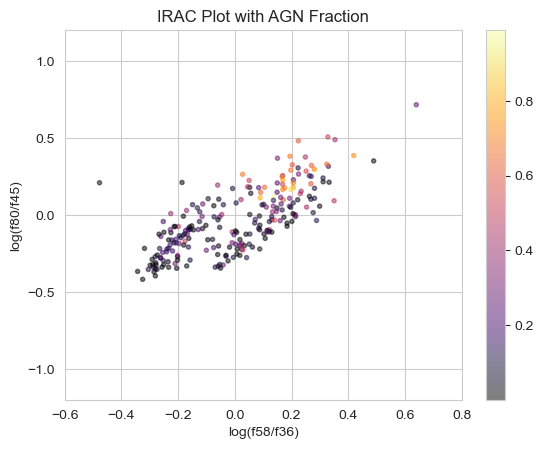

In [8]:

# IRAC plot
import matplotlib.colors as colors

plt.clf()
three_sig_limit = used_colours['red_diff'].std(ddof=3)
norm = colors.Normalize(vmin=-three_sig_limit, vmax=three_sig_limit)

plt.scatter(used_colours['x'], used_colours['y'], c=used_colours['red_diff'], cmap='PiYG', norm=norm, marker='.',
            alpha=0.9)
plt.xlim(-0.6, 0.8)
plt.ylim(-1.2, 1.2)
plt.colorbar()

plt.xlabel('log(f58/f36)')
plt.ylabel('log(f80/f45)')
plt.title('IRAC Plot with Redshift Difference')

# Plot Lacy Lines
x_boundary = np.linspace(-0.1, 2, 100)  # Adjust range as needed
y_boundary1 = -0.2 * np.ones_like(x_boundary)
y_boundary2 = 0.8 * x_boundary + 0.5
y_line = np.linspace(-0.2, 0.4, 100)
plt.plot(x_boundary, y_boundary1, color='red', linestyle='--')
plt.plot(x_boundary, y_boundary2, color='red', linestyle='--')
plt.plot(-0.1 * np.ones_like(y_line), y_line, color='red', linestyle='--')


# Define functions for boundary lines
def line1(x):
    return 1.21 * x - 0.27


def line2(x):
    return 1.21 * x + 0.27


# Generate x values for plotting lines
x_values1 = np.linspace(0.08, max(used_colours['x']), 100)
x_values2 = np.linspace(0.35, max(used_colours['x']), 100)

# Plot the lines
plt.plot(x_values2, line1(x_values2), color='magenta', linestyle='--')
plt.plot(x_values1, line2(x_values1), color='magenta', linestyle='--')
plt.plot(np.linspace(0.08, 0.35, 10), np.linspace(0.15, 0.15, 10), color='magenta', linestyle='--')
plt.plot(np.linspace(0.08, 0.08, 10), np.linspace(0.15, 0.35, 10), color='magenta', linestyle='--')
# IRAC plot
plt.clf()
plt.scatter(used_colours['x'], used_colours['y'], c=used_colours['agn_fraction'], cmap='inferno', marker='.', alpha=0.5)
plt.xlim(-0.6, 0.8)
plt.ylim(-1.2, 1.2)
plt.colorbar()

plt.xlabel('log(f58/f36)')
plt.ylabel('log(f80/f45)')
plt.title('IRAC Plot with AGN Fraction')

Text(0.5, 1.0, 'IRAC Plot with AGN Fraction')

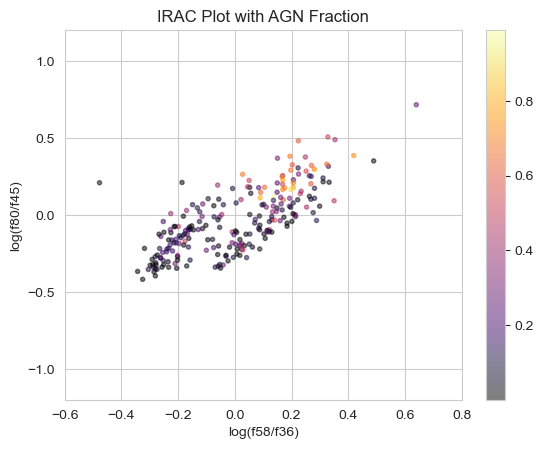

In [9]:

# Plot the lines
plt.plot(x_boundary, y_boundary1, color='red', linestyle='--')
plt.plot(x_boundary, y_boundary2, color='red', linestyle='--')
plt.plot(-0.1 * np.ones_like(y_line), y_line, color='red', linestyle='--')
plt.plot(x_values2, line1(x_values2), color='magenta', linestyle='--')
plt.plot(x_values1, line2(x_values1), color='magenta', linestyle='--')
plt.plot(np.linspace(0.08, 0.35, 10), np.linspace(0.15, 0.15, 10), color='magenta', linestyle='--')
plt.plot(np.linspace(0.08, 0.08, 10), np.linspace(0.15, 0.35, 10), color='magenta', linestyle='--')
# PLot With Template Colours shown
plt.clf()
plt.scatter(used_colours['x'], used_colours['y'], c=used_colours['agn_fraction'], cmap='inferno', marker='.', alpha=0.5)
plt.xlim(-0.6, 0.8)
plt.ylim(-1.2, 1.2)
plt.colorbar()

plt.xlabel('log(f58/f36)')
plt.ylabel('log(f80/f45)')
plt.title('IRAC Plot with AGN Fraction')

In [10]:

templates_graph = templates_use  # templates to be plotted
redshift_graph = np.linspace(0, 5, 50)  # redshifts to be plotted
for i in range(len(templates_graph)):
    for j in range(len(redshift_graph)):
        temp_redshift = template_colour_redshift(templates_graph[i], redshift_graph[j])
        temp_redshift.to_numpy()
        temp_redshift['x_axis'] = np.log10(used_colours['IRAC_58'] / used_colours['IRAC_36'])
        temp_redshift['y_axis'] = np.log10(used_colours['IRAC_80'] / used_colours['IRAC_45'])
        plt.plot(temp_redshift['y_axis'], temp_redshift['x_axis'], marker='o', c='green')


Redshift
Plot
with AGN fraction

Text(0.25, 0.85, 'Outliers: 12 / 116 : 10.34%')

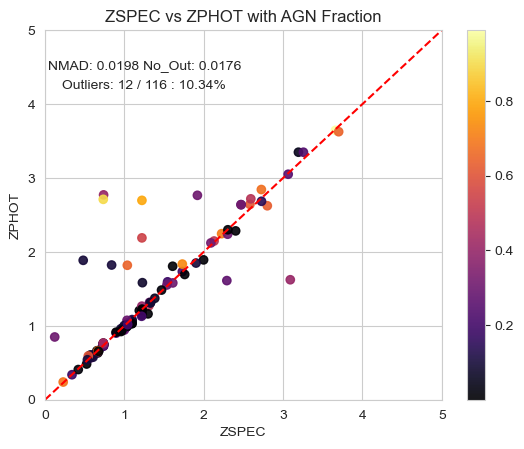

In [11]:
plt.clf()
plt.scatter(all_zphot_zspec['zspec'],
            all_zphot_zspec['zphot'],
            c=all_zphot_zspec['agn_fraction'], cmap='inferno', alpha=0.9, label='AGN Fraction')
plt.plot([0, 6], [0, 6], 'r--')
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.xlabel('ZSPEC')
plt.ylabel('ZPHOT')
plt.title('ZSPEC vs ZPHOT with AGN Fraction')
plt.colorbar()
plt.text(0.25, 0.9, f'NMAD: {total_nmad:.4f} No_Out: {outlier_nmad:.4f}', fontsize=10, horizontalalignment='center',
         verticalalignment='center', transform=plt.gca().transAxes)
plt.text(0.25, 0.85, f'Outliers: {outlier_count} / {len(all_zphot_zspec)} : {outlier_fraction:.2%}', fontsize=10,
         horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)


RedShift
Difference
Vs
AGN
Fraction

Text(0.7, 0.85, 'Outliers: 12 / 116 : 10.34%')

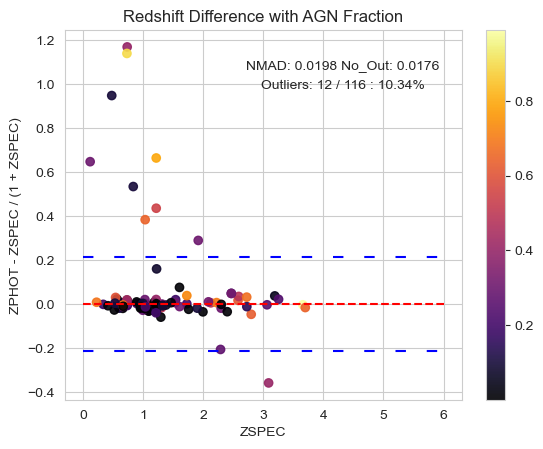

In [12]:
plt.clf()
plt.scatter(all_zphot_zspec['zspec'],
            all_zphot_zspec['compare'],
            c=all_zphot_zspec['agn_fraction'], cmap='inferno', alpha=0.9, label='AGN Fraction')
plt.plot([0, 6], [0, 0], 'r--')

three_sig_limit = all_zphot_zspec['compare'].std(ddof=3)
plt.plot([0, 6], [three_sig_limit, three_sig_limit], c='b', ls=(0, (5, 10)))
plt.plot([0, 6], [-three_sig_limit, -three_sig_limit], c='b', ls=(0, (5, 10)))
#plt.xlim(0, 6)
#plt.ylim(-0.8, 0.8)
plt.colorbar()
plt.xlabel('ZSPEC')
plt.ylabel('ZPHOT - ZSPEC / (1 + ZSPEC)')
plt.title('Redshift Difference with AGN Fraction')
plt.text(0.7, 0.9, f'NMAD: {total_nmad:.4f} No_Out: {outlier_nmad:.4f}', fontsize=10, horizontalalignment='center',
         verticalalignment='center', transform=plt.gca().transAxes)
plt.text(0.7, 0.85, f'Outliers: {outlier_count} / {len(all_zphot_zspec)} : {outlier_fraction:.2%}', fontsize=10,
         horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

Text(0.5, 1.0, 'Redshift Difference with No. of Filters')

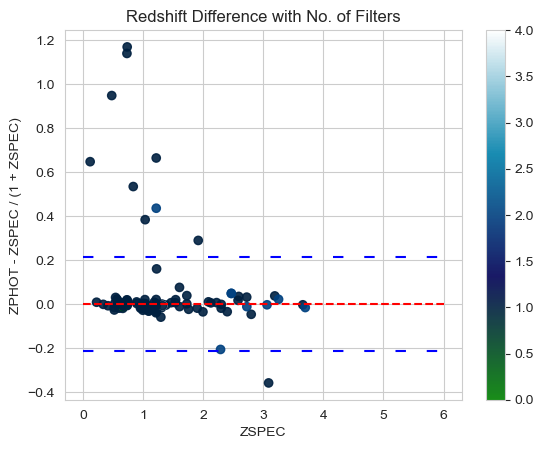

In [13]:
# see how many filters objects are present in
filter_count = [sum(self.fnu[object_id] <= 0) for object_id in all_zphot_zspec['id']]

plt.clf()
plt.scatter(all_zphot_zspec['zspec'],
            all_zphot_zspec['compare'],
            c=filter_count, cmap='ocean', alpha=0.9, label='AGN Fraction')
plt.plot([0, 6], [0, 0], 'r--')

three_sig_limit = all_zphot_zspec['compare'].std(ddof=3)
plt.plot([0, 6], [three_sig_limit, three_sig_limit], c='b', ls=(0, (5, 10)))
plt.plot([0, 6], [-three_sig_limit, -three_sig_limit], c='b', ls=(0, (5, 10)))
#plt.xlim(0, 6)
#plt.ylim(-0.8, 0.8)
plt.colorbar()
plt.xlabel('ZSPEC')
plt.ylabel('ZPHOT - ZSPEC / (1 + ZSPEC)')
plt.title('Redshift Difference with No. of Filters')

Text(0.5, 1.0, 'Redshift Difference with Average Filter Error')

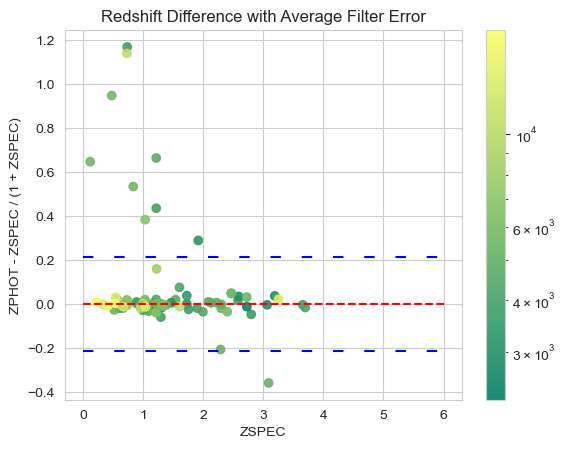

In [14]:
## Binned Graphs
# see filter error
import matplotlib.colors as colors

all_filter_error = pd.DataFrame(self.efnu).replace(99, np.nan, inplace=False)
filter_error = [np.mean(all_filter_error.loc[object_id, :]) for object_id in all_zphot_zspec['id']]

plt.clf()
plt.scatter(all_zphot_zspec['zspec'],
            all_zphot_zspec['compare'],
            c=filter_error,
            norm=colors.LogNorm(vmin=min(filter_error), vmax=max(filter_error)),
            cmap='summer', alpha=0.9, label='AGN Fraction')
plt.plot([0, 6], [0, 0], 'r--')

three_sig_limit = all_zphot_zspec['compare'].std(ddof=3)
plt.plot([0, 6], [three_sig_limit, three_sig_limit], c='b', ls=(0, (5, 10)))
plt.plot([0, 6], [-three_sig_limit, -three_sig_limit], c='b', ls=(0, (5, 10)))
#plt.xlim(0, 6)
#plt.ylim(-0.8, 0.8)
plt.colorbar()
plt.xlabel('ZSPEC')
plt.ylabel('ZPHOT - ZSPEC / (1 + ZSPEC)')
plt.title('Redshift Difference with Average Filter Error')

In [15]:
max(filter_error)

17774.388033048264

In [16]:
# worst fits
worst_fits = abs(all_zphot_zspec['compare'])
worst_fits = worst_fits.sort_values(ascending=True)
worst_fits.head(20)

98     0.000007
25     0.000801
42     0.001046
199    0.001083
68     0.001240
45     0.001281
147    0.001451
205    0.001507
150    0.002032
121    0.002225
34     0.002271
39     0.002325
126    0.002735
182    0.002790
66     0.003322
10     0.003359
206    0.003540
21     0.003871
88     0.003871
224    0.004211
Name: compare, dtype: float64

Counts: [ 1  0  1  0  1  1 10 30  3 22 17  7  9  8  6]
Total: 116
NMAD: [nan, nan, nan, nan, nan, nan, 0.02744295914002632, 0.01147746396545768, 0.3891167814082348, 0.011356589395727548, 0.024815404789702716, 0.027146954093895215, 0.022168347769921354, 0.024697387860758403, 0.03705556866487643]
Outliers: [0.0, nan, 0.0, nan, 0.0, 0.0, 0.1, 0.03333333333333333, 0.3333333333333333, 0.045454545454545456, 0.17647058823529413, 0.0, 0.2222222222222222, 0.0, 0.16666666666666666]
Fits: [nan, nan, nan, nan, nan, nan, 0.9704222051282051, 0.7495114358974359, 0.6297988461538462, 0.6967303076923077, 0.9197987692307692, 0.7354902307692307, 1.6649719102564102, 1.3060000512820513, 1.8396933333333334]


C:\Users\eddie\anaconda3\envs\SEDTemplate_conda\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\eddie\anaconda3\envs\SEDTemplate_conda\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\eddie\AppData\Local\Temp\ipykernel_20540\3476795946.py:21: RuntimeWarning: invalid value encountered in longlong_scalars
  bin_fraction = sum(outliers_bin) / counts_red[bin_loop]


<Figure size 640x480 with 0 Axes>

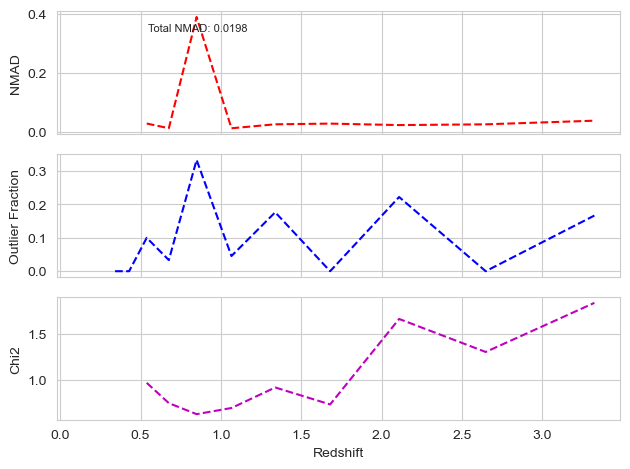

In [17]:
no_of_bins = 15  # no. of bins
logbins_start = np.log10(min(main_red['ZSPEC']))  # using logarithmic bins
logbins_end = np.log10(max(main_red['ZSPEC'])) + 1e-10  # adding a small value to include the last value
logbins = np.logspace(logbins_start, logbins_end, num=no_of_bins + 1)
counts_red, bins_red = np.histogram(main_red['ZSPEC'], bins=logbins)
print(f'Counts: {counts_red}')
print(f'Total: {len(main_red["ZSPEC"])}')
bin_centers_red = (np.array(bins_red[:-1]) + np.array(bins_red[1:])) / 2

last_val = 0  # last val is the first value within a bin (say object 2334), while new val is the last
nmad_red_val = []
outlier_frac_red = []
chi2_red = []
for bin_loop in range(no_of_bins):
    new_val = last_val + counts_red[bin_loop] - 1
    zspec_val = main_red['ZSPEC'][last_val:new_val]
    zphot_val = main_red['ZPHOT'][last_val:new_val]
    dz = (np.array(zphot_val) - np.array(zspec_val)) / (1 + np.array(zspec_val))
    nmad_red_val.append(astropy.stats.mad_std(dz))  # NMAD
    outliers_bin = np.abs(dz) >= catastrophic_limit
    bin_fraction = sum(outliers_bin) / counts_red[bin_loop]
    outlier_frac_red.append(bin_fraction)
    chi2_med = np.median(main_red['chi2'][last_val:new_val])  # chi2
    chi2_red.append(chi2_med)
    last_val = new_val + 1  # adding 1 to skip the last value of the previous bin

print(f'NMAD: {nmad_red_val}')
print(f'Outliers: {outlier_frac_red}')
print(f'Fits: {chi2_red}')

plt.clf()
fig, ax = plt.subplots(3, 1, sharex=True)

# NMAD
ax[0].plot(bin_centers_red, nmad_red_val, 'r--')
ax[0].set_ylabel('NMAD')
ax[0].text(0.25, 3.2, f'Total NMAD: {total_nmad:.4f}', fontsize=8, horizontalalignment='center',
           verticalalignment='center', transform=plt.gca().transAxes)

# Outliers
ax[1].plot(bin_centers_red, outlier_frac_red, 'b--')
ax[1].set_ylabel('Outlier Fraction')

# Chi2
ax[2].plot(bin_centers_red, chi2_red, 'm--')
ax[2].set_xlabel('Redshift')
ax[2].set_ylabel('Chi2')

fig.tight_layout()

plt.savefig(f'{output_directory}_RED.png')
plt.show()

Counts: [36 22  6 11 14  1  6  4  1  5  5  1  1  1  1]
NMAD: [0.020142715761696493, 0.020420415259329538, 0.0154267662219006, 0.008278575466373533, 0.022249451570518795, nan, 0.03165802822854926, 0.03266656641906014, nan, 0.05689446710656461, 0.009902671859398597, nan, nan, nan, nan]
Outliers: [0.0, 0.13636363636363635, 0.0, 0.0, 0.21428571428571427, 0.0, 0.3333333333333333, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0]
Fits: [0.7067605128205128, 0.82906, 0.8446623846153847, 0.7175171794871795, 0.7125441794871795, nan, 1.340607076923077, 1.4215543589743591, nan, 3.074547692307692, 2.5487646153846155, nan, nan, nan, nan]


<Figure size 640x480 with 0 Axes>

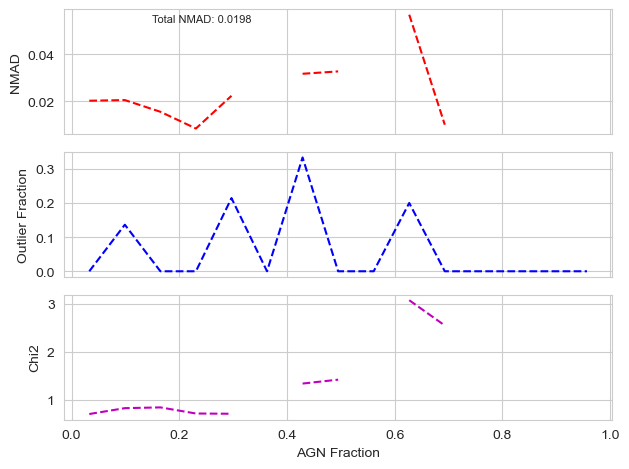

In [18]:
#NMAD against AGN fraction

counts_agn, bins_agn = np.histogram(main_agn['bayes.agn.fracAGN'], bins=no_of_bins)
print(f'Counts: {counts_agn}')
bin_centers_agn = (np.array(bins_agn[:-1]) + np.array(bins_agn[1:])) / 2

last_val = 0  # last val is the first value within a bin (say object 2334), while new val is the last
nmad_agn_val = []
outlier_frac_agn = []
chi2_agn = []
for bin_loop in range(no_of_bins):
    new_val = last_val + counts_agn[bin_loop] - 1
    zspec_val = main_agn['ZSPEC'][last_val:new_val]
    zphot_val = main_agn['ZPHOT'][last_val:new_val]
    dz = (np.array(zphot_val) - np.array(zspec_val)) / (1 + np.array(zspec_val))
    nmad_agn_val.append(astropy.stats.mad_std(dz))  # NMAD
    outliers_bin = np.abs(dz) >= catastrophic_limit  # outlier
    bin_fraction = sum(outliers_bin) / counts_agn[bin_loop]
    outlier_frac_agn.append(bin_fraction)
    chi2_med = np.median(main_agn['chi2'][last_val:new_val])  # chi2
    chi2_agn.append(chi2_med)
    last_val = new_val + 1  # adding 1 to skip the last value of the previous bin

print(f'NMAD: {nmad_agn_val}')
print(f'Outliers: {outlier_frac_agn}')
print(f'Fits: {chi2_agn}')

plt.clf()
fig, ax = plt.subplots(3, 1, sharex=True)

# NMAD
ax[0].plot(bin_centers_agn, nmad_agn_val, 'r--')
ax[0].set_ylabel('NMAD')
ax[0].text(0.25, 3.2, f'Total NMAD: {total_nmad:.4f}', fontsize=8, horizontalalignment='center',
           verticalalignment='center', transform=plt.gca().transAxes)

# Outliers
ax[1].plot(bin_centers_agn, outlier_frac_agn, 'b--')
ax[1].set_ylabel('Outlier Fraction')

# Chi2
ax[2].plot(bin_centers_agn, chi2_agn, 'm--')
ax[2].set_xlabel('AGN Fraction')
ax[2].set_ylabel('Chi2')

fig.tight_layout()

plt.savefig(f'{output_directory}_AGN.png')
plt.show()

Text(0.5, 1.0, 'Chi2 vs ZSPEC with Redshift Difference')

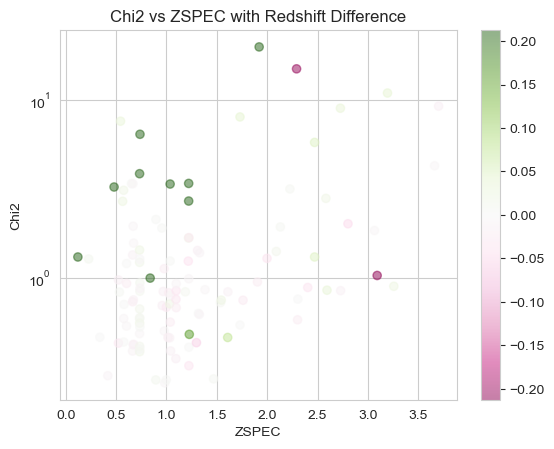

In [19]:
## Chi 2 Graphs
# Chi 2 against Spectroscopic Redshift
main_chi2 = main_red
main_chi2['compare'] = (main_chi2['ZPHOT'] - main_chi2['ZSPEC']) / (1 + main_chi2['ZSPEC'])  # redshift difference

plt.clf()
three_sig_limit = main_chi2['compare'].std(ddof=3)
norm = colors.Normalize(vmin=-three_sig_limit, vmax=three_sig_limit)

plt.scatter(main_chi2['ZSPEC'], main_chi2['chi2'], c=main_chi2['compare'], cmap='PiYG', norm=norm, alpha=0.5)
plt.colorbar()
plt.xlabel('ZSPEC')
plt.ylabel('Chi2')
plt.yscale('log')
plt.title('Chi2 vs ZSPEC with Redshift Difference')

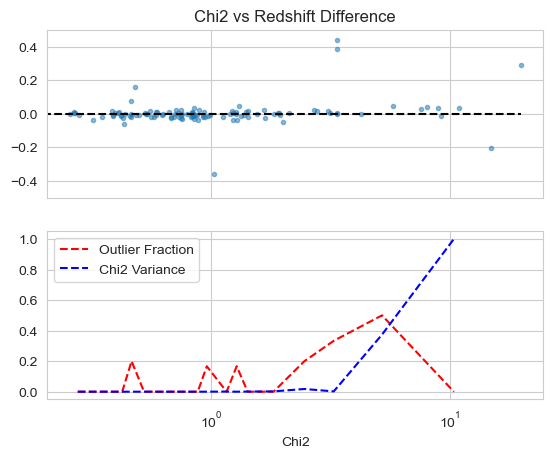

In [20]:
no_of_bins = 20
bin_edges = pd.qcut(main_chi2['chi2'], no_of_bins)
bin_edges = bin_edges.cat.categories
chi2_bins = np.zeros([no_of_bins, 3])
for i in range(no_of_bins):
    min_loop = bin_edges[i].left
    max_loop = bin_edges[i].right
    bin_values = main_chi2[(main_chi2['chi2'] >= min_loop) & (main_chi2['chi2'] <= max_loop)]
    chi2_bins[i, 0] = sum(bin_values['compare'] >= catastrophic_limit) / len(
        bin_values)  # outlier fraction (outliers / total)
    chi2_bins[i, 1] = np.std(bin_values['chi2']) ** 2  # chi2 variance
    chi2_bins[i, 2] = np.mean(bin_values['chi2'])  # chi2 mean

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.scatter(main_chi2['chi2'], main_chi2['compare'], marker='.', alpha=0.5)
ax1.plot([0, max(main_chi2['chi2'])], [0, 0], 'k--')
#ax1.ylabel('ZPHOT - ZSPEC / (1 + ZSPEC)')
ax1.set_ylim(-0.5, 0.5)
ax1.set_title('Chi2 vs Redshift Difference')

ax2.plot(chi2_bins[:, 2], chi2_bins[:, 0], 'r--', label='Outlier Fraction')
ax2.plot(chi2_bins[:, 2], chi2_bins[:, 1] / max(chi2_bins[:, 1]), 'b--', label='Chi2 Variance')
ax2.legend()
ax2.set_xlabel('Chi2')
ax2.set_xscale('log')

In [21]:

## Redshift Vs AGN Fraction
delta_z = (np.array(main_agn['ZPHOT']) - np.array(main_agn['ZSPEC'])) / (1 + np.array(main_agn['ZSPEC']))
red_agn_plot = pd.DataFrame(columns=['delta_z', 'agn_fraction'])
red_agn_plot['delta_z'] = delta_z
agn_fraction = main_agn['bayes.agn.fracAGN']
agn_fraction.index = range(len(agn_fraction))
red_agn_plot['agn_fraction'] = agn_fraction
red_agn_plot = red_agn_plot.sort_values(by=['agn_fraction'])
#red_agn_plot = red_agn_plot[abs(red_agn_plot['delta_z']) <= catastrophic_limit]

no_of_bins_red_agn = 30
bin_edges = pd.qcut(red_agn_plot['agn_fraction'], no_of_bins_red_agn)
bin_edges = bin_edges.cat.categories
red_agn_bins = np.zeros([no_of_bins_red_agn, 2])

for i in range(no_of_bins_red_agn):
    min_loop = bin_edges[i].left
    max_loop = bin_edges[i].right
    bin_values = red_agn_plot[(red_agn_plot['agn_fraction'] >= min_loop) & (red_agn_plot['agn_fraction'] <= max_loop)]
    red_agn_bins[i, 0] = np.mean(bin_values['delta_z'])
    red_agn_bins[i, 1] = np.mean(bin_values['agn_fraction'])

Text(0.5, 1.0, 'Redshift vs AGN Fraction')

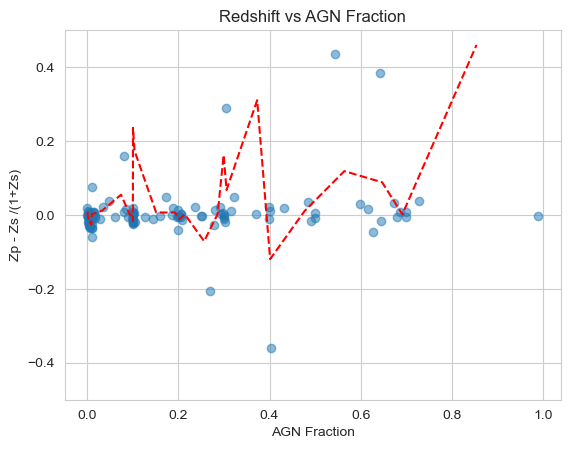

In [22]:
plt.clf()
plt.scatter(red_agn_plot['agn_fraction'], red_agn_plot['delta_z'], alpha=0.5)
plt.plot(red_agn_bins[:, 1], red_agn_bins[:, 0], 'r--')
plt.ylim(-0.5, 0.5)
plt.xlabel('AGN Fraction')
plt.ylabel('Zp - Zs /(1+Zs)')
plt.title('Redshift vs AGN Fraction')

Residuals

In [24]:
#limit the no of objects to those that are present in all bands, and have a positive redshift
flux_observed = []
flux_residual_objects = []

# Filter section
filter_attendance = 39  # can miss 1 filter and still be selected
for i in range(len(self.fnu)):
    if self.ZSPEC[i] < 0.001:
        continue
    if sum(self.fnu[i] <= 0) > filter_attendance:
        continue  # don't use objects where more than filter attendance filters are missing (eg. if one filter_attendance is 1, if one filter is missing it still goes forward, if two are missing it doesn't)
    else:
        flux_observed.append(self.fnu[i])
        flux_residual_objects.append(i)
flux_observed = np.array(flux_observed)

#find the residuals of the objects
flux_model = self.fmodel[flux_residual_objects]
error_observed = self.efnu[flux_residual_objects]
flux_residual = np.zeros_like(flux_observed)
residual_uncertainties = []
for row in range(len(flux_residual_objects)):
    residual_uncertainties.append(error_observed[row] / flux_observed[row])
    for col in range(flux_observed.shape[1]):  #no. of bands
        if flux_observed[row, col] == -99:  # if the flux is -99, it is not recorded and should not be shown as such
            flux_residual[row, col] = math.nan
        elif flux_model[row, col] == 0:  # some models have no flux, this means they will be removed later
            flux_residual[row, col] = math.nan
        else:
            flux_residual[row, col] = (flux_observed[row, col] - flux_model[row, col]) / flux_observed[row, col]

#flux_residual = flux_residual[~np.isnan(flux_residual).any(axis=1)] # remove nan values
residual_uncertainties = np.array(residual_uncertainties)

#redshift the objects
object_redshifted = []
pivots = self.pivot
for i in range(len(flux_residual_objects)):
    im = flux_residual_objects[i]
    redshifted = pivots / (1 + self.ZSPEC[im])
    object_redshifted.append(redshifted)
object_redshifted = np.array(object_redshifted)

In [25]:
pd.DataFrame(flux_model).describe()

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
count,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,...,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000
mean,65.753728,89.622718,101.854552,117.586354,101.179140,101.071310,39.677357,44.866748,53.720404,72.094085,...,15.775213,19.447912,21.865708,24.129555,27.062022,8.679816,14.005956,3.960688,101.308828,101.712629
std,148.865707,155.807368,132.682432,129.433606,138.279691,138.125888,63.434889,71.256545,84.515020,108.424630,...,34.441160,38.112314,40.929944,44.793883,47.314008,25.652813,31.799051,13.518950,138.436702,138.905249
min,4.223108,6.146849,6.322331,5.671344,4.570497,4.585757,0.708889,0.876964,1.348426,2.817495,...,0.190836,0.246376,0.282326,0.301140,0.307073,0.094732,0.165854,0.003104,4.599226,4.674439
25%,23.548165,31.473345,37.384272,38.168107,22.708654,22.670269,6.242702,7.288470,10.290402,16.063401,...,1.827969,2.149644,2.894489,3.339297,3.635168,1.015733,1.784122,0.460783,22.679968,22.938263
50%,42.187544,58.962555,71.299605,78.374190,54.450575,54.393697,19.342427,24.987904,30.068483,37.342917,...,4.488713,6.207616,7.956099,10.146894,12.149003,2.406035,4.161795,0.976208,54.631763,55.128515
75%,68.737018,93.130862,120.259130,151.523408,104.119350,104.044414,40.590874,45.363616,50.345935,70.128573,...,13.370292,19.253165,21.820911,24.338274,27.519160,6.267120,11.924198,2.490625,104.294202,104.815045
max,1587.147200,1601.156100,1226.109300,914.681760,850.516800,850.101400,388.886300,446.908330,545.394350,679.562870,...,231.211960,227.978640,227.730600,266.910060,286.907380,237.165560,230.458570,136.938160,852.757900,858.148560


In [26]:
#plot the residuals
wavelength_flat = object_redshifted.flatten()
residual_flat = flux_residual.flatten()
uncertainties_flat = residual_uncertainties.flatten()

#binning
obj_per_bin = round(0.5 * sum(self.ZSPEC > 0.001))  #EAZY used 2000
res_sorted = pd.DataFrame(
    {'wavelength': wavelength_flat, 'residual': residual_flat, 'uncertainties': uncertainties_flat})
res_sorted = res_sorted.sort_values(by='wavelength')
res_sorted = res_sorted.dropna(how='any')  # remove nan
res_std = np.std(res_sorted['residual'])
res_sorted = res_sorted[abs(res_sorted['residual']) < 3 * res_std]  # remove 3sig outliers
no_of_bins_res = np.ceil(len(res_sorted) // obj_per_bin)
res_sorted = res_sorted.reset_index(drop=True)
res_sorted_copy = res_sorted  # not abs
res_sorted = abs(res_sorted)
res_bin = pd.DataFrame(columns=["Median Residuals", "Median Wavelength", "Median Uncertainties", "Confidence"])
res_bin_copy = pd.DataFrame(columns=["Median Residuals", "Median Wavelength", "Median Uncertainties", 'Confidence'])
for i in range(int(no_of_bins_res)):
    min_loop = i * obj_per_bin
    max_loop = ((i + 1) * obj_per_bin)
    med_res = np.median(res_sorted['residual'][min_loop:max_loop])
    med_res_copy = np.median(
        res_sorted_copy['residual'][min_loop:max_loop])  # only the residuals should be affected by abs
    med_wave = np.median(res_sorted['wavelength'][min_loop:max_loop])
    med_unc = np.median(res_sorted['uncertainties'][min_loop:max_loop])
    confidence = (50 / 68.2) * 1.2533 * (np.std(res_sorted_copy['residual'][min_loop:max_loop]) / np.sqrt(
        obj_per_bin))  # want 50% confidence interval from standard error of the median
    res_bin.loc[i] = [med_res, med_wave, med_unc, confidence]
    res_bin_copy.loc[i] = [med_res_copy, med_wave, med_unc,
                           confidence]  # copy is not abs, used in plot with negative values

In [27]:
res_sorted.describe()

,wavelength,residual,uncertainties
count,4402.000000,4402.000000,4402.000000
mean,7122.356631,0.088033,167.669726
std,8046.920695,0.241237,1567.581595
min,784.348881,0.000015,0.000113
25%,2830.148768,0.017251,0.004098
50%,4234.354405,0.040859,0.012234
75%,7737.414868,0.083450,0.043925
max,70550.344166,9.426764,42340.531639


<Figure size 640x480 with 0 Axes>

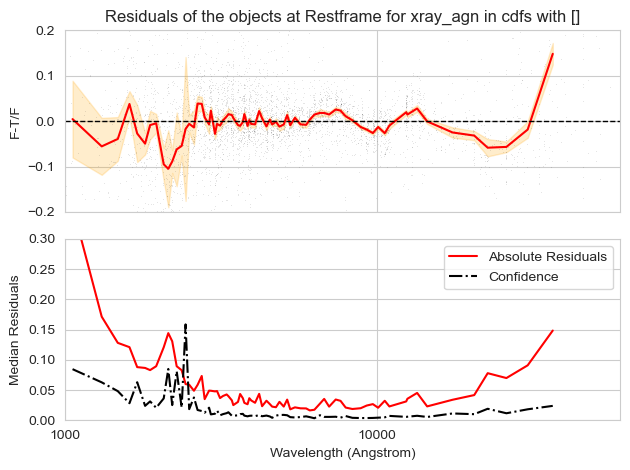

In [28]:
plt.clf()
fig, ax = plt.subplots(2, 1, sharex=True)
fig.gca().set_xscale('log')
fig.gca().xaxis.set_major_formatter('{x:.0f}')

ax[0].plot(wavelength_flat, residual_flat, 'k,', alpha=0.1)
ax[0].plot(res_bin_copy["Median Wavelength"], res_bin_copy["Median Residuals"], 'r')
ax[0].fill_between(res_bin_copy["Median Wavelength"],
                   res_bin_copy["Median Residuals"] - res_bin["Confidence"],
                   res_bin_copy["Median Residuals"] + res_bin["Confidence"], alpha=0.2, color='orange')
ax[0].axhline(y=0, color='black', linestyle='--', linewidth=1)
ax[0].set_ylim(-0.2, 0.2)
ax[0].set_xlim(1e3, 6e4)
ax[0].set_ylabel('F-T/F')
ax[0].set_title(f'Residuals of the objects at Restframe for {id_key} in {field} with {agn_sed}')

ax[1].plot(res_bin["Median Wavelength"], res_bin["Median Residuals"], 'r', label='Absolute Residuals')
# ax[1].plot(res_bin["Median Wavelength"], res_bin["Median Uncertainties"], 'b-.', label='Uncertainties')
ax[1].plot(res_bin["Median Wavelength"], res_bin["Confidence"], 'k-.', label='Confidence')
ax[1].set_ylim(0, 0.3)
ax[1].set_ylabel('Median Residuals')
ax[1].set_xlabel('Wavelength (Angstrom)')
ax[1].legend()

fig.tight_layout()

#plt.savefig(f'{output_directory}_residuals.png')
plt.show()

Quick
look
at
the
likelihoods

In [29]:
object_lnp = 53


def normalizer(data):
    """
    Normalizes the data to a 0-1 scale
    """
    return (data - min(data)) / (max(data) - min(data))


plt.plot(self.zgrid, normalizer(self.lnp[object_lnp]), label="lnp")
plt.plot(self.zgrid, normalizer(self.full_logprior[object_lnp]), label="logprior")
plt.legend()
z_lnp_max, lnp_max = self.get_maxlnp_redshift(prior=False, beta_prior=False)
print(
    f"Max lnp:{self.zgrid[self.lnp[object_lnp].argmax()]}\nMax lnp fitted: {z_lnp_max[object_lnp]}\nZ Best: {self.zbest[object_lnp]}")

AttributeError: 'self_load' object has no attribute 'zgrid'